# TP2

Alumno: Maximiliano Medina


Implementar la función create_gauss_filter (h, w, k_size, sigma) para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.
1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral.
2. Usando el método descripto en el paper Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral
3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape from focus”

#### Importar librerías

In [46]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### 1

In [179]:
img = cv2.imread('puma.png',cv2.IMREAD_GRAYSCALE)
h,w = img.shape

In [180]:
def create_gaussian_kernel(kernel_size, sigma):

    if kernel_size % 2 == 0: kernel_size += 1
    gaussian_kernel = cv2.getGaussianKernel(kernel_size, sigma)
    gaussian_kernel_2d = np.outer(gaussian_kernel, gaussian_kernel.T)
    gaussian_kernel_2d = gaussian_kernel_2d / np.sum(gaussian_kernel_2d)

    return gaussian_kernel_2d

In [181]:
def create_gauss_filter(h, w, k_size, sigma):
    gaussian_kernel = create_gaussian_kernel(k_size, sigma)
    gaussian = np.zeros((h,w))

    xfiltro = gaussian.shape[1]  
    yfiltro = gaussian.shape[0]
    xkernel = gaussian_kernel.shape[1]
    ykernel = gaussian_kernel.shape[0]

    x_offset=int((xfiltro - xkernel)/2)
    y_offset=int((yfiltro - ykernel)/2)
    gaussian[y_offset:y_offset+ykernel, x_offset:x_offset+xkernel] = gaussian_kernel

    gaussian_fft = np.fft.fft2(gaussian)
    return gaussian, gaussian_fft

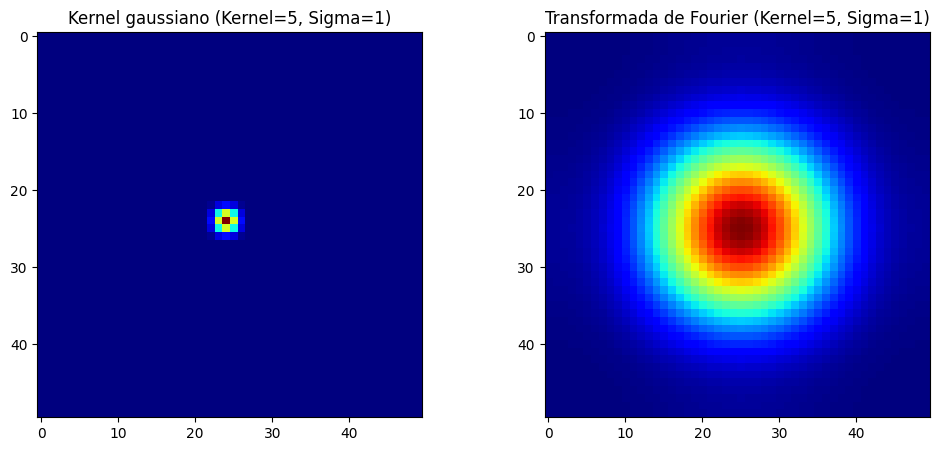

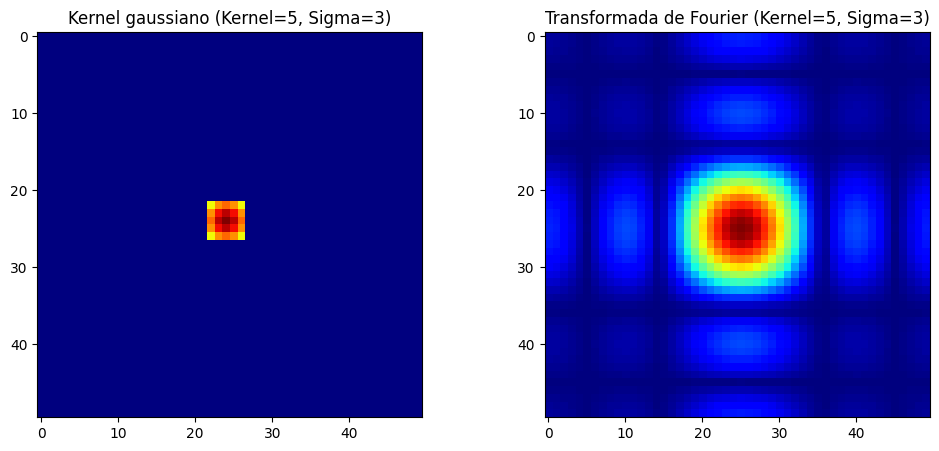

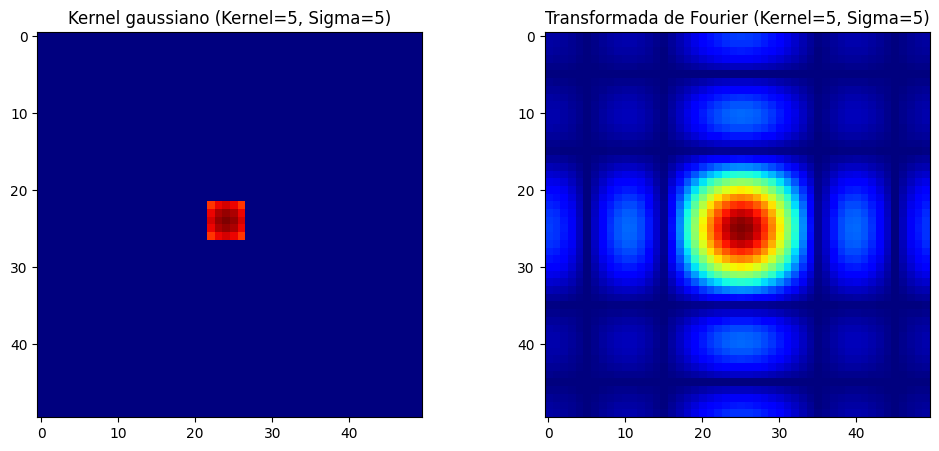

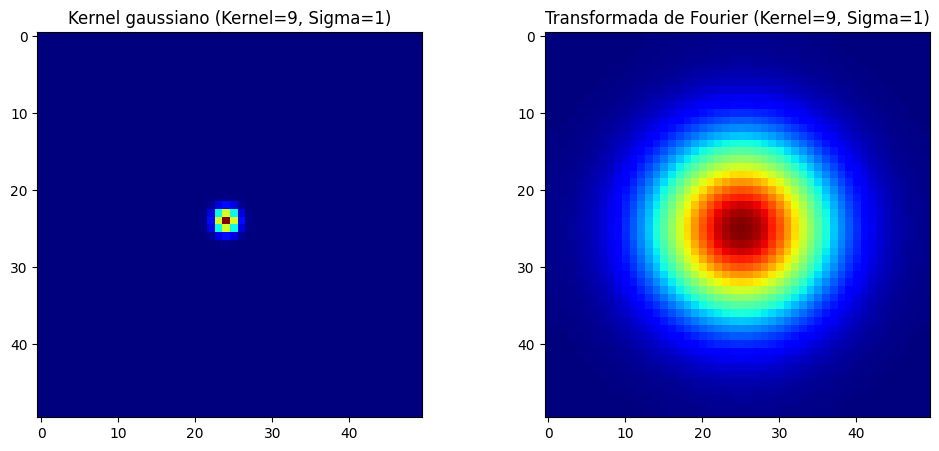

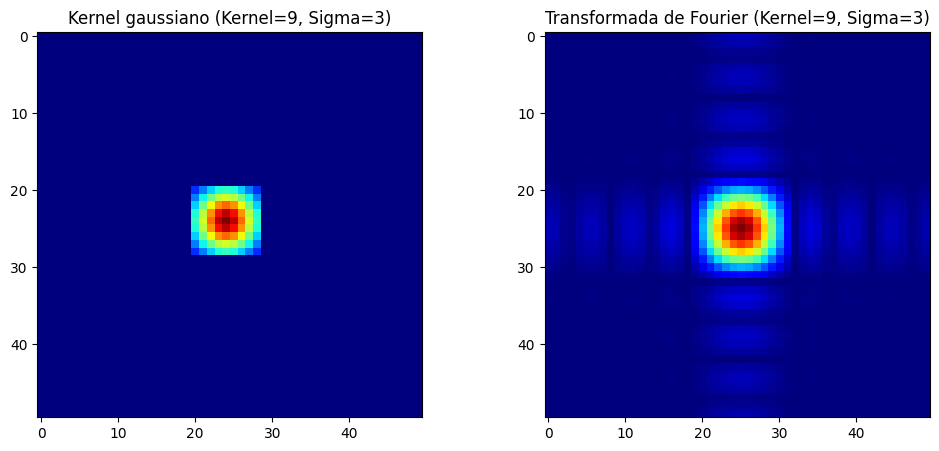

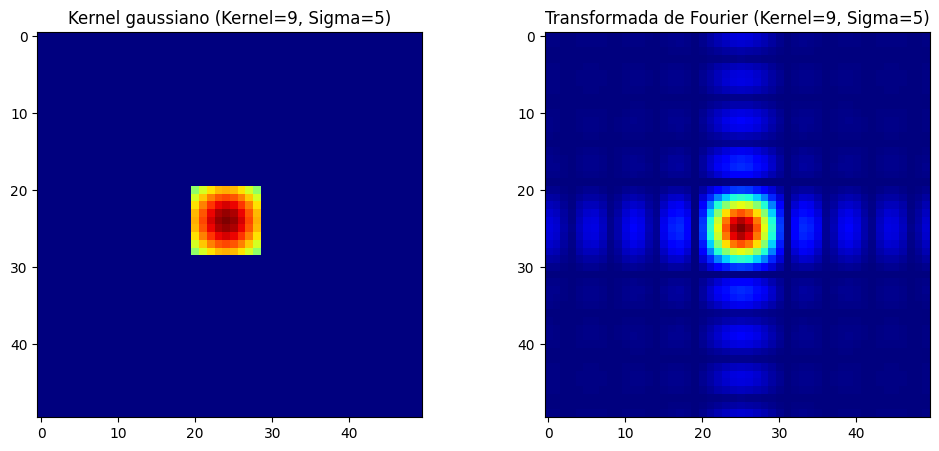

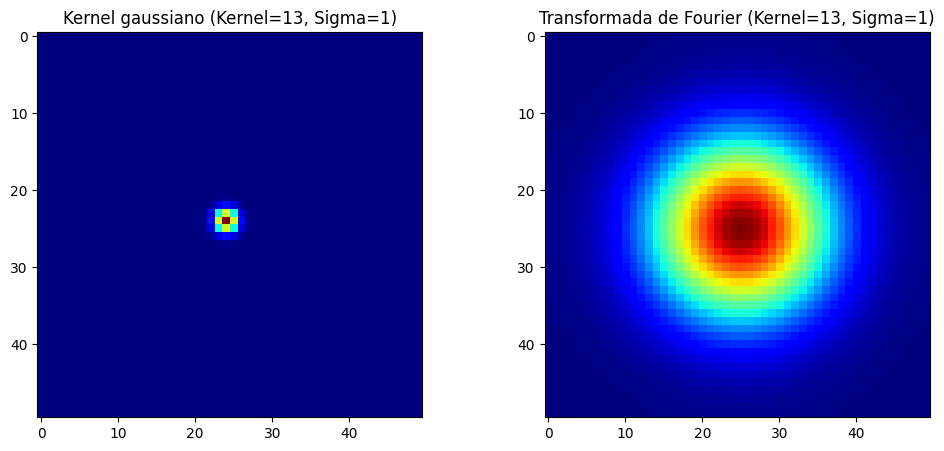

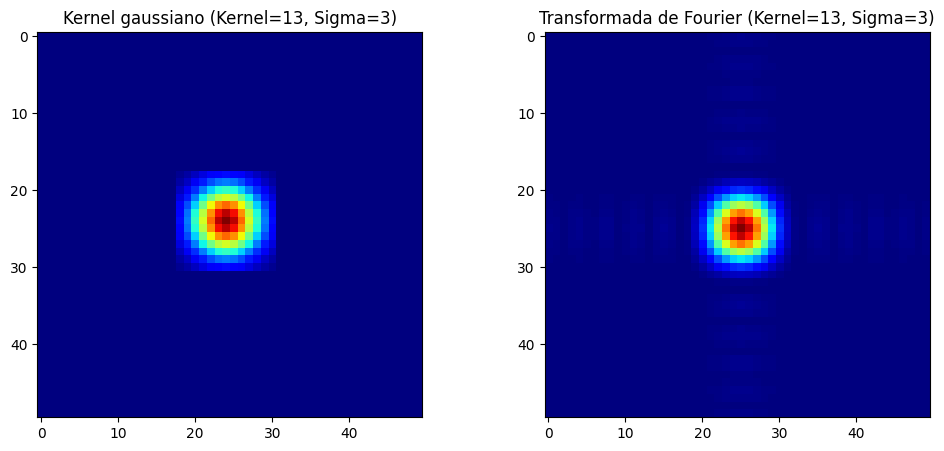

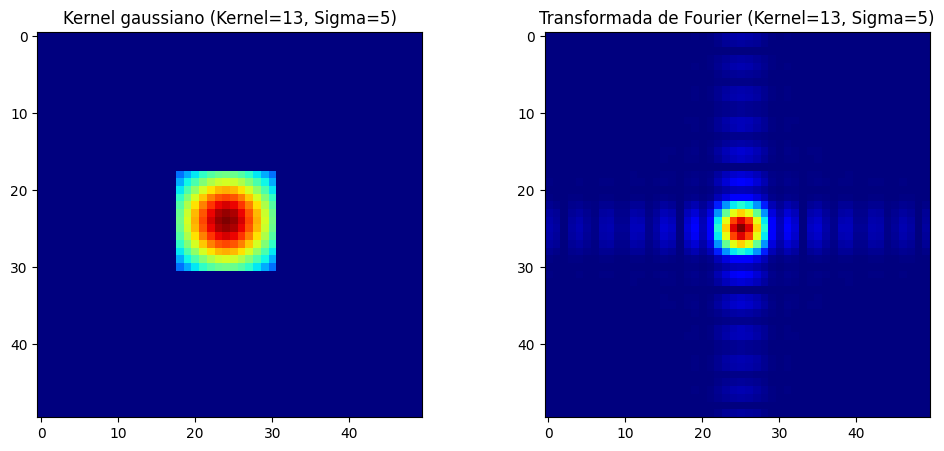

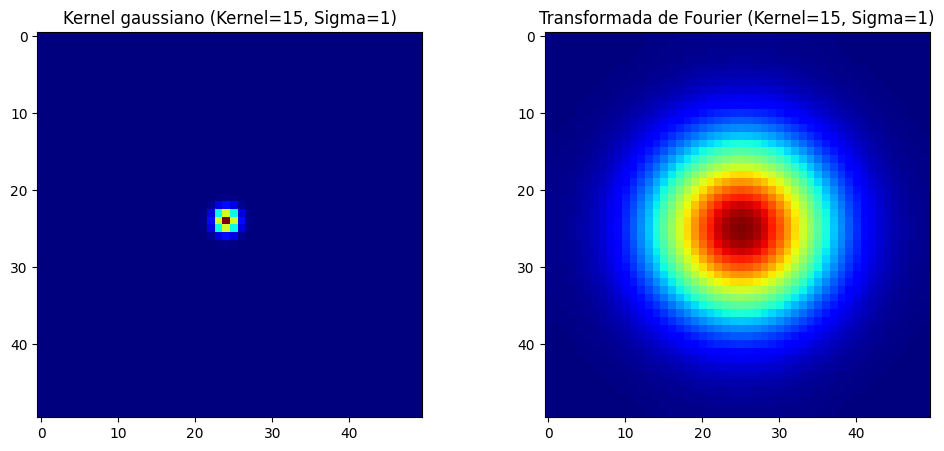

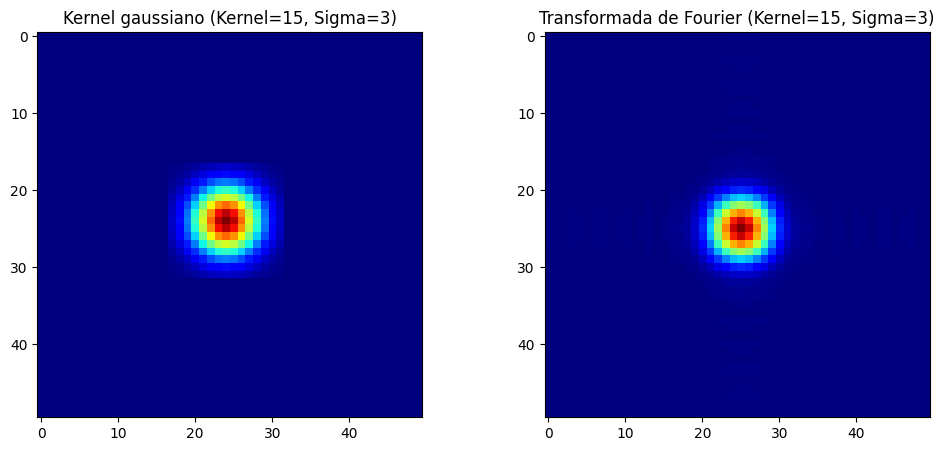

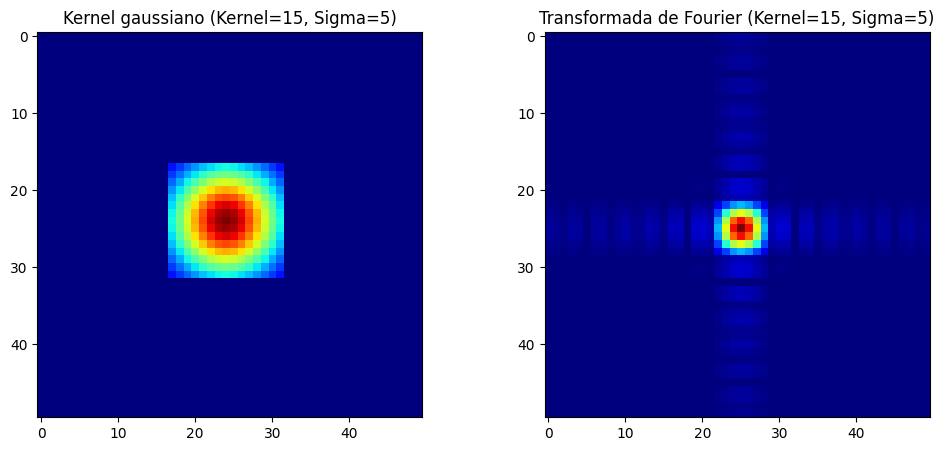

In [182]:
k_sizes = [5, 9, 13, 15]
sigmas = [1, 3, 5]

# Crear y graficar los filtros gaussiano y su transformada de Fourier
for k_size in k_sizes:
    for sigma in sigmas:
        gauss_filter, fft_gauss_filter = create_gauss_filter(50, 50, k_size, sigma)
        fig = plt.figure(figsize=(12, 5))

        plt.subplot(1,2,1)
        plt.imshow(gauss_filter, cmap='jet'),plt.title(f'Kernel gaussiano (Kernel={k_size}, Sigma={sigma})')

        tf_shifted = np.fft.fftshift(fft_gauss_filter)
        plt.subplot(1,2,2)
        plt.imshow(np.abs(tf_shifted), cmap='jet'),plt.title(f'Transformada de Fourier (Kernel={k_size}, Sigma={sigma})')

In [183]:
def spectral_filter(img, fft_gauss_filter):
    img_fft = np.fft.fft2(img)
    img_fft = img_fft * fft_gauss_filter
    img_fft = np.fft.ifftshift(np.real(np.fft.ifft2(img_fft)))
    return img_fft

(<matplotlib.image.AxesImage at 0x25f42767260>,
 Text(0.5, 1.0, 'Imagen filtrada'))

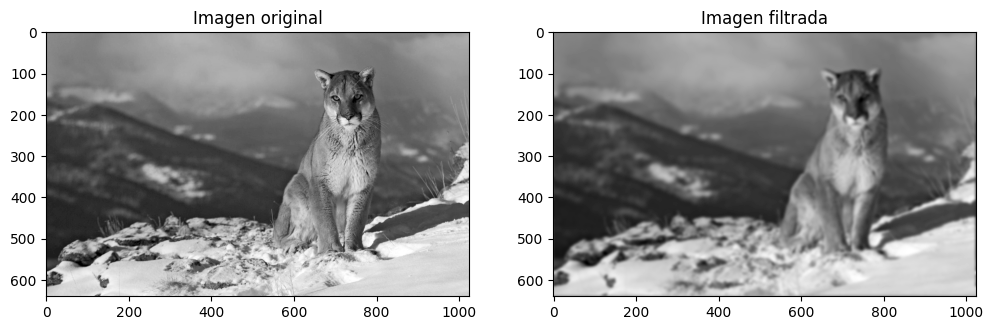

In [184]:
gauss_filter, fft_gauss_filter = create_gauss_filter(h, w, k_size=15, sigma=3.0)
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray'),plt.title('Imagen original')
plt.subplot(1,2,2)
plt.imshow(spectral_filter(img, fft_gauss_filter), cmap='gray'),plt.title('Imagen filtrada')

#### 2

In [185]:
def quality_measure(img):    
    F = np.fft.fft2(img)
    Fc = np.fft.fftshift(F)
    AF = np.abs(Fc)
    M = np.max(AF)
    TH = np.sum(AF > M / 1000)
    FM = TH / (img.shape[0] * img.shape[1])
    return FM

(<matplotlib.image.AxesImage at 0x25f27699190>,
 Text(0.5, 1.0, 'Filtro espectral - FM: 0.00406341552734375'))

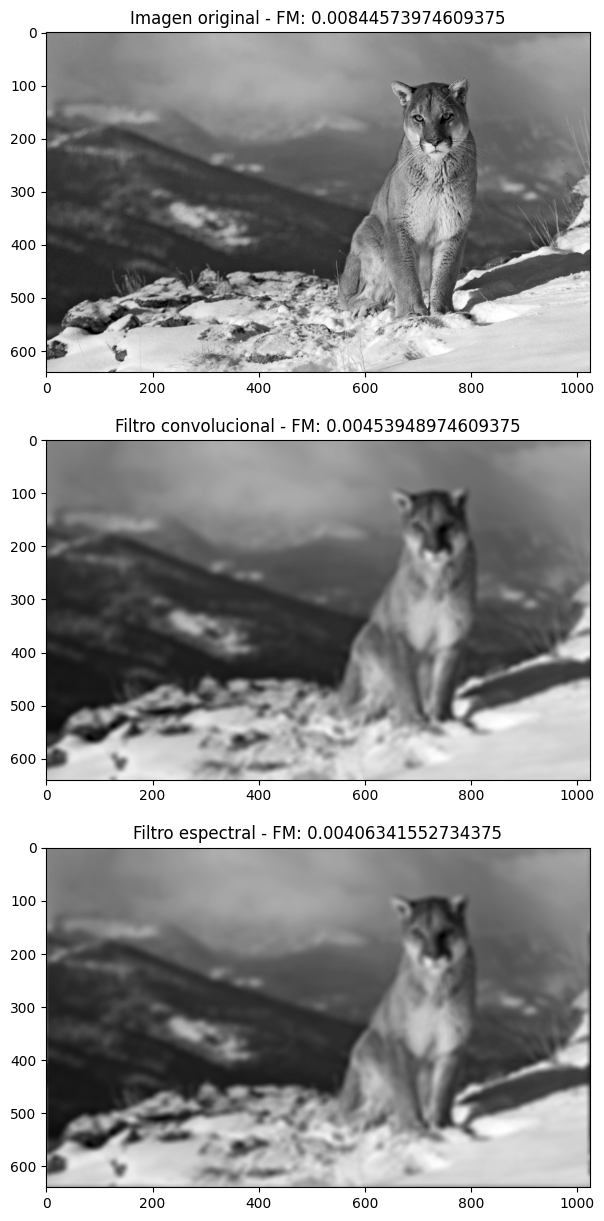

In [186]:
k_size = 15
sigma = 5

# filtro para convolución
gaussian_kernel = create_gaussian_kernel(k_size, sigma)
convolved_image = cv2.filter2D(img, -1, gaussian_kernel)

# filtro para filtrado espectral
gauss_filter, fft_gauss_filter = create_gauss_filter(h, w, k_size, sigma)
spectral_filtered_image = spectral_filter(img, fft_gauss_filter)

plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
plt.imshow(img, cmap='gray'), plt.title(f'Imagen original - FM: {quality_measure(img)}')
plt.subplot(3,1,2)
plt.imshow(convolved_image, cmap='gray'), plt.title(f'Filtro convolucional - FM: {quality_measure(convolved_image)}')
plt.subplot(3,1,3)
plt.imshow(spectral_filtered_image.astype(np.uint8), cmap='gray'), plt.title(f'Filtro espectral - FM: {quality_measure(spectral_filtered_image)}')

#### Comparacion tamaño kernel

[0.00791168212890625, 0.00713043212890625, 0.00633392333984375, 0.00572967529296875, 0.00525054931640625, 0.00482940673828125, 0.00453948974609375]
[0.00781402587890625, 0.00695343017578125, 0.00607757568359375, 0.00538177490234375, 0.00487518310546875, 0.00442352294921875, 0.00406341552734375]


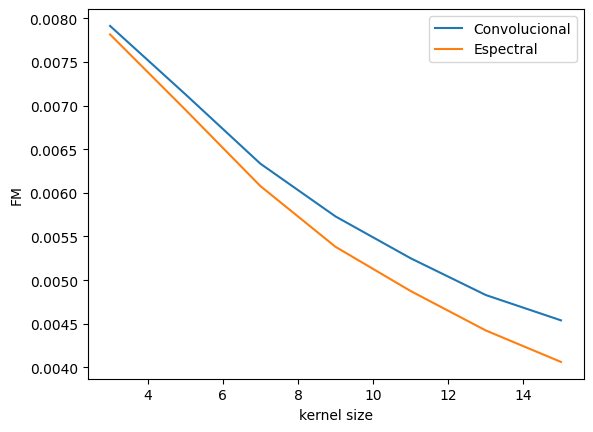

In [187]:
k_sizes = [3, 5, 7, 9, 11, 13, 15]
sigma=5
quality_imgs_conv=[]
quality_imgs_spec=[]

for k_size in k_sizes:
    gaussian_kernel = create_gaussian_kernel(k_size, sigma)

    # Filtro gaussiano para convolución.
    convolved_filtered_image = cv2.filter2D(img, -1, gaussian_kernel)
    quality_imgs_conv.append(quality_measure(convolved_filtered_image))

    # Filtro gaussiano para filtrado espectral
    gauss_filter, fft_gauss_filter = create_gauss_filter(h, w, k_size, sigma)
    spectral_filtered_image = spectral_filter(img, fft_gauss_filter)
    quality_imgs_spec.append(quality_measure(spectral_filtered_image))
print (quality_imgs_conv)
print (quality_imgs_spec)

plt.figure()
plt.plot(k_sizes, quality_imgs_conv, label='Convolucional')
plt.plot(k_sizes, quality_imgs_spec, label='Espectral')
plt.xlabel('kernel size')
plt.ylabel('FM')
plt.legend()

#### Comparacion desvio estandar

[0.00768280029296875, 0.00632781982421875, 0.00538482666015625, 0.00479278564453125, 0.00453948974609375, 0.00437774658203125, 0.00428314208984375, 0.00422210693359375, 0.00416717529296875, 0.00414276123046875]
[0.00756988525390625, 0.00605010986328125, 0.00500640869140625, 0.00438690185546875, 0.00406341552734375, 0.00391998291015625, 0.00381927490234375, 0.00374603271484375, 0.00369110107421875, 0.00366363525390625]


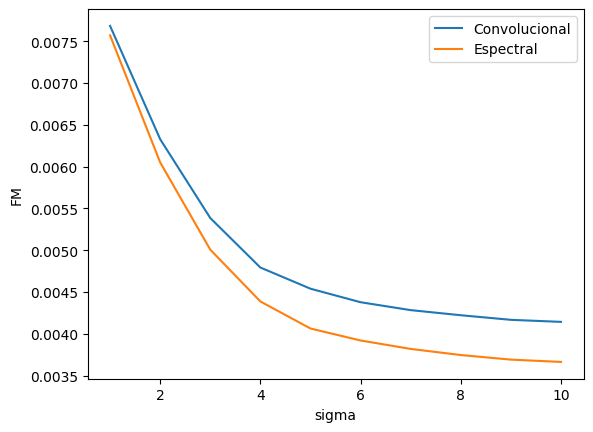

In [188]:
k_size=15
sigmas = [1,2,3,4,5,6,7,8,9,10]
quality_imgs_conv=[]
quality_imgs_spec=[]

for sigma in sigmas:
    gaussian_kernel = create_gaussian_kernel(k_size, sigma)

    # Filtro gaussiano para convolución.
    convolved_filtered_image = cv2.filter2D(img, -1, gaussian_kernel)
    quality_imgs_conv.append(quality_measure(convolved_filtered_image))

    # Filtro gaussiano para filtrado espectral
    gauss_filter, fft_gauss_filter = create_gauss_filter(h, w, k_size, sigma)
    spectral_filtered_image = spectral_filter(img, fft_gauss_filter)
    quality_imgs_spec.append(quality_measure(spectral_filtered_image))

print (quality_imgs_conv)
print (quality_imgs_spec)

plt.figure()
plt.plot(sigmas, quality_imgs_conv, label='Convolucional')
plt.plot(sigmas, quality_imgs_spec, label='Espectral')
plt.xlabel('sigma')
plt.ylabel('FM')
plt.legend()

Podemos ver que a mayor valor de sigma con tamaño de kernel constante y mayor tamaño de kernel con sigma constante la imagen se ve mas desenfocada. En cuanto a los valores de medida de calidad (FM) el filtro espectral es mas sensible a la variacion de estos parametros siendo, ademas, siempre menores a los del filtro convolucional.

#### 3

In [189]:
# Metodo A.15. Tenengrad (GRA6)
def tenengrad(img):
    gradientX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    gradientY = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    return np.sum(gradientX ** 2 + gradientY ** 2)

#### Comparacion tamaño kernel

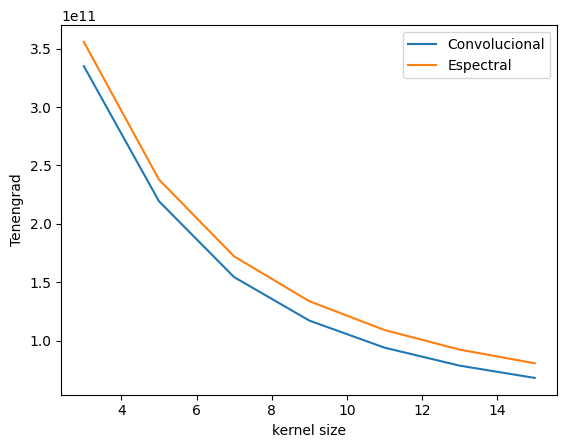

In [190]:
k_sizes = [3, 5, 7, 9, 11, 13, 15]
sigma=5
quality_imgs_conv_tenengrad=[]
quality_imgs_spec_tenengrad=[]

for k_size in k_sizes:
    gaussian_kernel = create_gaussian_kernel(k_size, sigma)

    # Filtro gaussiano para convolución.
    convolved_filtered_image = cv2.filter2D(img, -1, gaussian_kernel)
    quality_imgs_conv_tenengrad.append(tenengrad(convolved_filtered_image))

    # Filtro gaussiano para filtrado espectral
    gauss_filter, fft_gauss_filter = create_gauss_filter(h, w, k_size, sigma)
    spectral_filtered_image = spectral_filter(img, fft_gauss_filter)
    quality_imgs_spec_tenengrad.append(tenengrad(spectral_filtered_image))

plt.figure()
plt.plot(k_sizes, quality_imgs_conv_tenengrad, label='Convolucional')
plt.plot(k_sizes, quality_imgs_spec_tenengrad, label='Espectral')
plt.xlabel('kernel size')
plt.ylabel('Tenengrad')
plt.legend()

#### Comparacion desvio estandar

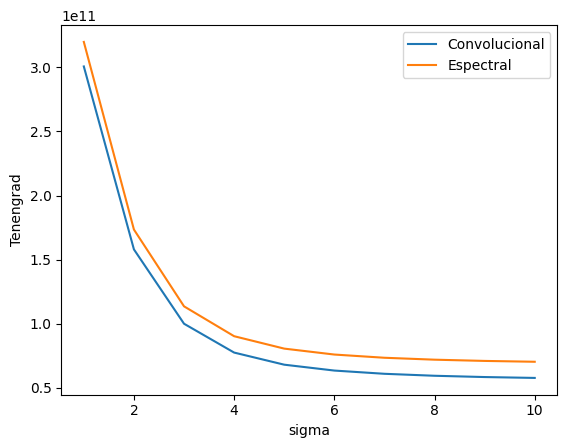

In [191]:
k_size=15
sigmas = [1,2,3,4,5,6,7,8,9,10]
quality_imgs_conv_tenengrad=[]
quality_imgs_spec_tenengrad=[]

for sigma in sigmas:
    gaussian_kernel = create_gaussian_kernel(k_size, sigma)

    # Filtro gaussiano para convolución.
    convolved_filtered_image = cv2.filter2D(img, -1, gaussian_kernel)
    quality_imgs_conv_tenengrad.append(tenengrad(convolved_filtered_image))

    # Filtro gaussiano para filtrado espectral
    gauss_filter, fft_gauss_filter = create_gauss_filter(h, w, k_size, sigma)
    spectral_filtered_image = spectral_filter(img, fft_gauss_filter)
    quality_imgs_spec_tenengrad.append(tenengrad(spectral_filtered_image))

plt.figure()
plt.plot(sigmas, quality_imgs_conv_tenengrad, label='Convolucional')
plt.plot(sigmas, quality_imgs_spec_tenengrad, label='Espectral')
plt.xlabel('sigma')
plt.ylabel('Tenengrad')
plt.legend()

Podemos ver que a mayor valor de sigma con tamaño de kernel constante y mayor tamaño de kernel con sigma constante la imagen se ve mas desenfocada. Los valores de la metrica Tenengrad varian en similar proporcion, siendo siempre menores los del filtro convolucional.